In [1]:
import os
import random
import math
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms.functional as F
from torchvision import datasets, models, transforms
from torchvision.models.detection.retinanet import RetinaNet
from torchvision.models.detection.faster_rcnn import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.retinanet import RetinaNetHead

from IPython.display import clear_output
from tqdm import tqdm
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Hack_targets/

/content/drive/MyDrive/Hack_targets


In [ ]:
# from zipfile import ZipFile
# with ZipFile('public_test.zip', 'r') as zipObj:
#    zipObj.extractall()

In [4]:
def get_transform(train, target_size, norm=True):
    transform = []
    transform.append(transforms.ToTensor())
    transform.append(transforms.Resize(target_size))
    if norm:
        transform.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    # if train:
    #     # during training, randomly flip the training images
    #     # and ground-truth for data augmentation
    #     transform.append(transforms.RandomHorizontalFlip(0.5))
    return transforms.Compose(transform)

In [5]:
class TrainData(Dataset):
    def __init__(self, all_paths, train=True, target_size=(224, 224)):
        self.all_paths = all_paths
        self.class_mapper = {'human':0, 'target_human':1, 'target_laser':2, 'target_gun':3, 'target_tank':4}
        self.train = train
        self.target_size = target_size

    def __len__(self) -> int:
        return len(self.all_paths)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.all_paths[idx]
        image = Image.open(img_name).convert('RGB')
        # image = transforms.ToTensor()(image).unsqueeze_(0)
        # image = transforms.Resize(size=(224, 224))(image)

        preprocess = get_transform(self.train, self.target_size)
        image = preprocess(image)
        
        name = img_name.split('/')[-1]
        target = None
        for key in self.class_mapper:
            if name.startswith(key):
                target = self.class_mapper[key]
        labels = torch.tensor(target)

        sample = {'image': image, 'label': labels}

        return sample

In [ ]:
data = TrainData(glob.glob('dataset/train/*.jpg'))
means_r = []
stds_r = []
means_g = []
stds_g = []
means_b = []
stds_b = []
for img in tqdm(data):
    means_r.append(torch.mean(img['image'][0]))
    stds_r.append(torch.std(img['image'][0]))
    means_g.append(torch.mean(img['image'][1]))
    stds_g.append(torch.std(img['image'][1]))
    means_b.append(torch.mean(img['image'][2]))
    stds_b.append(torch.std(img['image'][2]))

mean_r = torch.mean(torch.tensor(means_r))
std_r = torch.mean(torch.tensor(stds_r))
mean_g = torch.mean(torch.tensor(means_g))
std_g = torch.mean(torch.tensor(stds_g))
mean_b = torch.mean(torch.tensor(means_b))
std_b = torch.mean(torch.tensor(stds_b))

100%|██████████| 18525/18525 [56:56<00:00,  5.42it/s]


In [ ]:
print(mean_r, mean_g, mean_b)
print(std_r, std_g, std_b)

tensor(0.3862) tensor(0.3872) tensor(0.3216)
tensor(0.1521) tensor(0.1439) tensor(0.1225)


In [ ]:
all_images = glob.glob('dataset/train/*.jpg')
all_targets = []
class_mapper = {'human':0, 'target_human':1, 'target_laser':2, 'target_gun':3, 'target_tank':4}
for path in all_images:
    name = path.split('/')[-1]
    for key in class_mapper:
        if name.startswith(key):
            all_targets.append(class_mapper[key])

In [ ]:
images_train, images_test = train_test_split(all_images, test_size=0.2, random_state=42, stratify=all_targets)

In [ ]:
batch_size = 64
train_dataset = TrainData(images_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_dataset = TrainData(images_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 224, 224])


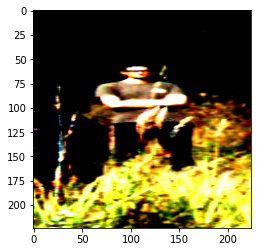

In [ ]:
for sample in train_dataloader:
    print(sample['image'].shape)
    plt.imshow(sample['image'][6].permute(1, 2, 0))
    break

In [ ]:
def plot_progress(train_losses, train_accs, test_loss, test_accs, train_class_acc, test_class_acc):
    clear_output(True)
    mapper = {0:'human', 1:'target_human', 2:'target_laser', 3:'target_gun', 4:'target_tank'}
    f, axes = plt.subplots(nrows=3, ncols=3)
    f.set_figheight(12)
    f.set_figwidth(20)
    
    axes[0][0].plot(train_losses, label='train loss')
    axes[0][0].plot(test_loss, label='test loss')
    axes[0][0].plot(np.zeros_like(train_losses), '--', label='zero')
    axes[0][0].set_title('Loss')
    axes[0][0].set_ylabel('Loss')
    axes[0][0].set_xlabel('Batch number')
    axes[0][0].legend()
    
    axes[1][0].plot(train_accs, label='train balanced accuracy')
    axes[1][0].plot(test_accs, label='test balanced accuracy')
    axes[1][0].plot(np.ones_like(accs), '--', label='100% accuracy')
    axes[1][0].set_title('Accuracy')
    axes[1][0].set_ylabel('Accuracy')
    axes[1][0].set_xlabel('Batch number')
    axes[1][0].legend()

    for i in range(5):
        axes[1 + (i > 1)][(i + 1) % 3].plot(train_class_acc[i], label='train balanced accuracy')
        axes[1 + (i > 1)][(i + 1) % 3].plot(test_class_acc[i], label='test balanced accuracy')
        axes[1 + (i > 1)][(i + 1) % 3].plot(np.ones_like(accs), '--', label='100% accuracy')
        axes[1 + (i > 1)][(i + 1) % 3].set_title('Accuracy ' + mapper[i])
        axes[1 + (i > 1)][(i + 1) % 3].set_ylabel('Accuracy')
        axes[1 + (i > 1)][(i + 1) % 3].set_xlabel('Batch number')
        axes[1 + (i > 1)][(i + 1) % 3].legend()

    f.tight_layout()
    plt.show()

In [6]:
def compute_accuracy(pred, target):
    targets_ammount = [0 for i in range(5)]
    correct_preds = [0 for i in range(5)]
    
    for files, tar in enumerate(target):
        targets_ammount[tar] +=1
       # print(file, tar, target[file], pred[file])
        if pred[files] == tar:
            correct_preds[tar] +=1
    
    avg_acc = sum(correct_preds)/sum(targets_ammount)
    
    per_target_acc = [correct_preds[i]/targets_ammount[i] if targets_ammount[i] else 0 for i in range(5)]
    
    weights = [0.4, 0.3, 0.09, 0.12, 0.06]
    absolute_score = sum([per_target_acc[i]/weights[i] for i in range(5)])

    # print('avg_acc {}, per_class_acc human:{} target_human:{} target_laser:{} target_gun:{} target_tank:{}'.format(avg_acc,*per_target_acc))
    # print('score {}'.format(absolute_score))
    
    return avg_acc, per_target_acc

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# !pip install efficientnet_pytorch

In [ ]:
# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b0')

# in_features = model._fc.in_features
# model._fc = nn.Linear(in_features, 5)

In [8]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001, betas=(0.9, 0.999))

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) 

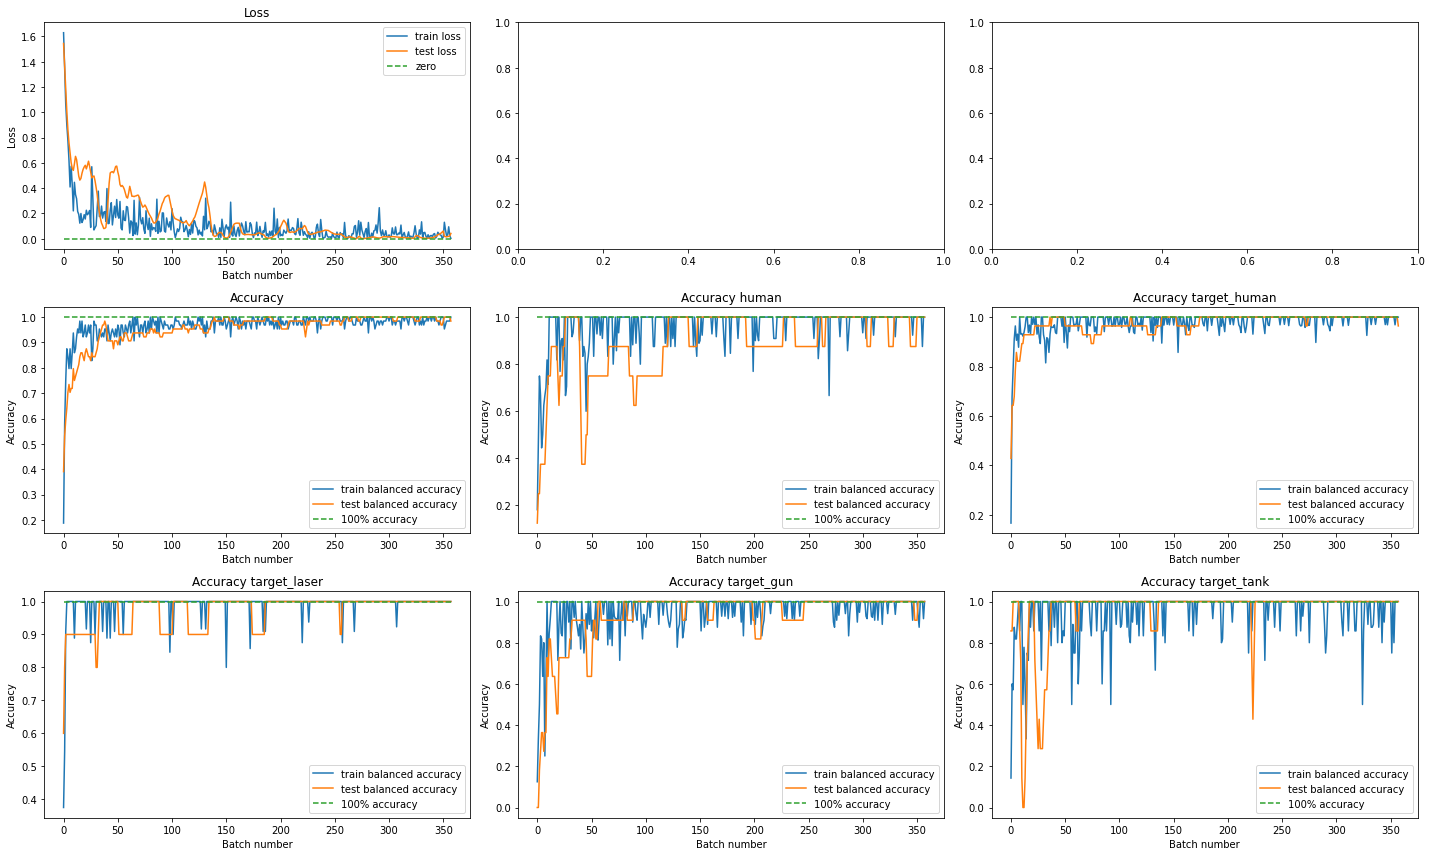

KeyboardInterrupt: ignored

In [ ]:
epochs = 10

accs = []
test_accs = []

train_losses = []
test_losses = []

train_class_acc = {0: [], 1: [], 2: [], 3: [], 4: []}
test_class_acc = {0: [], 1: [], 2: [], 3: [], 4: []}

for epoch in range(epochs):
    for train in train_dataloader:
        model.train()
        data_train = train['image'].to(device)#.permute(0, 3, 1, 2)
        target_train = train['label'].to(device)

        optimizer.zero_grad()
        out_train = model(data_train.float())
        _, preds_train = torch.max(out_train, 1)
        train_loss = criterion(out_train, target_train)
        # train_loss = criterion(target_train.float(), out_train.reshape(-1))

        train_loss.backward()
        optimizer.step()
        
        test = next(iter(test_dataloader))
        model.eval()
        with torch.no_grad():
            data_test = test['image'].to(device)#.permute(0, 3, 1, 2)
            target_test = test['label'].to(device)
            out_test = model(data_test.float())
            _, preds_test = torch.max(out_test, 1)
            test_loss = criterion(out_test, target_test)
            # test_loss = criterion(target_test.float(), out_test.reshape(-1))

        avg_acc_train, per_target_acc_train = compute_accuracy(preds_train, target_train)
        accs.append(avg_acc_train)

        avg_acc_test, per_target_acc_test = compute_accuracy(preds_test, target_test)
        test_accs.append(avg_acc_test)
        
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())

        for i in range(5):
            train_class_acc[i].append(per_target_acc_train[i])
            test_class_acc[i].append(per_target_acc_test[i])
        
        plot_progress(train_losses, accs, test_losses, test_accs, train_class_acc, test_class_acc)

In [ ]:
# torch.save(model, 'weights/effnet_1.pth')
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': test_accs[-1]
#             }, 'weights/checkpoint_effnet_1.pth')

## Final results

In [11]:
from zipfile import ZipFile
with ZipFile('private_test.zip', 'r') as zipObj:
   zipObj.extractall()

In [9]:
model = torch.load('weights/resnet18_1.pth')

In [10]:
dummy_input = torch.randn(64, 3, 224, 224).to(device)
torch.onnx.export(model, dummy_input, "weights/resnet18_1.onnx", verbose=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


graph(%input.1 : Float(64, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cuda:0),
      %fc.weight : Float(5, 512, strides=[512, 1], requires_grad=1, device=cuda:0),
      %fc.bias : Float(5, strides=[1], requires_grad=1, device=cuda:0),
      %193 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=0, device=cuda:0),
      %194 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %196 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %197 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %199 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %200 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %202 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %203 : Float(64, strides=[1], requires_grad=0, device=cuda:0),
      %205 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cuda:0),
      %206 :

In [12]:
# model = torch.load('weights/resnet18_1.pth')
model.eval()
preprocess = get_transform(False, (224, 224))
sub = []
for i in tqdm(glob.glob('private_test/*.jpg')):
    img_name = i.split('/')[-1]
    image = Image.open(i).convert('RGB')
    image = preprocess(image)
    with torch.no_grad():
        image = image.unsqueeze_(0).to(device)
        out_test = model(image.float())
        _, preds_test = torch.max(out_test, 1)
        preds_test = preds_test.cpu().numpy()[0]
        sub.append([preds_test, img_name])
submit = pd.DataFrame(sub)

100%|██████████| 4738/4738 [00:32<00:00, 144.67it/s]


In [15]:
submit.to_csv('Two_Unknown_Geese.csv', header=None, index=None)

In [16]:
submit

,0,1
0,1,camera_2_41310.jpg
1,3,camera_2_17255.jpg
2,3,camera_2_43116.jpg
3,3,camera_2_495119.jpg
4,0,camera_2_225820.jpg
...,...,...
4733,4,camera_2_4504695.jpg
4734,1,camera_2_47524714.jpg
4735,1,camera_2_32254715.jpg
4736,1,camera_2_19644716.jpg


## Public Test

In [ ]:
# model = torch.load('weights/resnet18_1.pth')
model.eval()
sub = []
for i, fold in enumerate(['human', 'target_1human', 'target_2laser', 'target_3gun', 'target_4tank']):
    for img_name in tqdm(glob.glob('public_test/' + fold + '/*.jpg')):
        name = img_name.split('/')[-1]
        image = Image.open(img_name).convert('RGB')
        preprocess = get_transform(False, (224, 224))
        image = preprocess(image)
        with torch.no_grad():
            image = image.unsqueeze_(0).to(device)
            out_test = model(image.float())
            _, preds_test = torch.max(out_test, 1)
            preds_test = preds_test.cpu().numpy()[0]
            sub.append([preds_test, name, i])
submit = pd.DataFrame(sub)

In [ ]:
compute_accuracy(submit[0], submit[2])

(0.9768280123583934,
 [0.96875, 0.9933333333333333, 0.9888888888888889, 0.9421487603305785, 1.0])

In [ ]:
submit[[0, 1]].to_csv('public_part.csv', index=False, header=None)

## Saliency maps

In [ ]:
import numpy as np
import sys
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.cm as cm

from PIL import Image

In [ ]:
def load_raw_image(norm=True):
    """Load raw 224x224 center crop of image"""
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    img_name = 'dataset/train/target_human_camera3_3004_16019781142360702001058x1165.jpg'
    # img_name = 'dataset/train/human_camera1_30194_4298324202486290x71.jpg'
    image = Image.open(img_name).convert('RGB')
    preprocess = get_transform(False, (224, 224), norm)
    image = preprocess(image)
    image = image.unsqueeze_(0).to(device)
    return image

In [ ]:
def get_model():
    """Get model, set forward hook to save second-to-last layer's output"""
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features

    model = model.to(device)
    model = torch.load('weights/resnet18_1.pth')
    model.eval()

    layer = model.layer4[1].conv2

    def store_feature_map(self, _, output):
        self._parameters['out'] = output
    layer.register_forward_hook(store_feature_map)

    return model, layer

In [ ]:
def compute_cam(net, layer, pred):
    """Compute class activation maps

    :param net: network that ran inference
    :param layer: layer to compute cam on
    :param int pred: prediction to compute cam for
    """

    # 1. get second-to-last-layer output
    features = layer._parameters['out'][0]

    # 2. get weights w_1, w_2, ... w_n
    weights = net.fc._parameters['weight'][pred]

    # 3. compute weighted sum of output
    cam = (features.T * weights).sum(2)

    # normalize cam
    cam -= cam.min()
    cam /= cam.max()
    cam = cam.detach().cpu().numpy()
    return cam

In [ ]:
def save_cam(cam):
    # save heatmap
    heatmap = (cm.jet_r(cam) * 255.0)[..., 2::-1].astype(np.uint8)
    heatmap = Image.fromarray(heatmap).resize((224, 224))
    heatmap.save('heatmap.jpg')
    print(' * Wrote heatmap to heatmap.jpg')

    # save heatmap on image
    image = load_raw_image(norm=False)
    image = image[0].permute(1, 2, 0)
    image = image.detach().cpu().numpy()
    combined = (np.array(image) * 255 * 0.7 + np.array(heatmap) * 0.3).astype(np.uint8)
    Image.fromarray(combined).save('combined.jpg')
    print(' * Wrote heatmap on image to combined.jpg')

In [ ]:
x = load_raw_image()
net, layer = get_model()

out = net(x)
_, (pred,) = torch.max(out, 1)  # get class with highest probability

cam = compute_cam(net, layer, pred)
save_cam(cam)

cuda:0
cuda:0
 * Wrote heatmap to heatmap.jpg
cuda:0
 * Wrote heatmap on image to combined.jpg
